In [136]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures

# Years case

In [147]:
windows_map = read_ontario(granularity='years')
pollutans = ['NOx', 'O3']
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [148]:
month_ids = [date.month for date in dates]
year_ids = [date.year for date in dates]


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

In [149]:
mts = TSerie(X=windows, y = station_ids)

mts.smooth(window_size=50)

mts.shapeNormalizization()

# mts.minMaxNormalizization()


Loaded mts - N: 202, T: 365, D: 2 
(202, 2, 365)


In [154]:
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'shape' # subsequences - shape
EPOCHS = 150
BATCH_SIZE = 32
ENC_SIZE = 8
mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = [16, 32, 32], 
    conv_kernels = [7, 7, 7],
)

Epoch[1] Train loss    avg: 2.747081126485552
Epoch[10] Train loss    avg: 1.3527239731379919
Epoch[20] Train loss    avg: 1.273891908781869
Epoch[30] Train loss    avg: 1.2595877136502946
Epoch[40] Train loss    avg: 1.187584979193551
Epoch[50] Train loss    avg: 1.1888356719698225
Epoch[60] Train loss    avg: 1.1987316949026925
Epoch[70] Train loss    avg: 1.1768004042761666
Epoch[80] Train loss    avg: 1.1710856642041887
Epoch[90] Train loss    avg: 1.1784380844661169
Epoch[100] Train loss    avg: 1.173235365322658
Epoch[110] Train loss    avg: 1.1616106714521135
Epoch[120] Train loss    avg: 1.1830146312713623
Epoch[130] Train loss    avg: 1.173693299293518
Epoch[140] Train loss    avg: 1.1494215045656477
Epoch[150] Train loss    avg: 1.1520653452192033


In [155]:
import umap

reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
coords = reducer.fit_transform(mts.features)

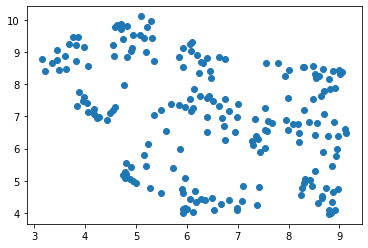

In [156]:
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1])

In [158]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

storage = MTSStorage('mts_test')    
# storage.delete()
storage.load()

dimensions = pollutans
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    'Test' , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        # 'shape': coords,
        # 'magnitude': coords_mean,
        'coords': coords,
    }
)



storage.save()

mts shape: N: 202 -  T: 365 - D: 4


# Months case

In [85]:
windows_map = read_ontario(granularity='months')
pollutans = ['SO2']
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [86]:
windows.shape

(4158, 28, 2)

In [87]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [126]:
mts = TSerie(X=windows, y = station_ids)

mts.smooth(window_size=8)

mts.shapeNormalizization()

# mts.minMaxNormalizization()

Loaded mts - N: 57, T: 365, D: 1 
(57, 1, 365)


In [127]:
LOSS = 'SupConLoss' # SupConLoss | SimCLR
MODE = 'shape' # subsequences - shape
EPOCHS = 31
BATCH_SIZE = 32
ENC_SIZE = 8
mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = [16, 32, 32], 
    conv_kernels = [7, 7, 7]
)

Epoch[1] Train loss    avg: 6.371222257614136
Epoch[10] Train loss    avg: 3.9762654304504395
Epoch[20] Train loss    avg: 3.700909972190857
Epoch[30] Train loss    avg: 3.6796053647994995


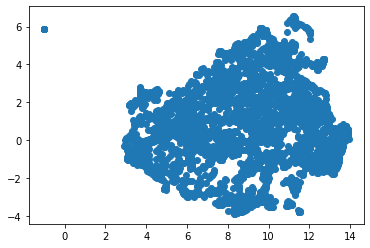

In [112]:
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
coords = reducer.fit_transform(mts.features)
plt.scatter(coords[:, 0], coords[:, 1])

In [113]:

storage = MTSStorage('mts_test')    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    'Test months' , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= 600
)

storage.save()

mts shape: N: 4158 -  T: 28 - D: 4
